In [1]:
import pickle
import numpy as np
from pathlib import Path

RIDGE_PATH_2 = Path("/jet/home/ypan14/ridge/subject2ridge_streaming_80_20_k_3.pkl")
RIDGE_PATH_3 = Path("/jet/home/ypan14/ridge/subject3ridge_streaming_80_20_k_3.pkl")

with open(RIDGE_PATH_2, "rb") as f:
    res2 = pickle.load(f)

# finetuned bert model
W        = res2["W"]                # (D, V)
metrics  = res2["metrics"]
test_corr = metrics["test_corr"]    # (V,)
mean_X   = res2["mean_X"]           # (D,)
std_X    = res2["std_X"]            # (D,)
mean_Y   = res2["mean_Y"]           # (V,)
std_Y    = res2["std_Y"]            # (V,)
train_files = res2["train_files"]   # list of paths (str)
test_files  = res2["test_files"]

In [2]:
train_files = [
    f.replace("/ocean/projects/mth250011p/smazioud/preprocessing",
              "/ocean/projects/mth250011p/ypan14/preprocessing_clean")
    for f in res2["train_files"]
]

test_files = [
    f.replace("/ocean/projects/mth250011p/smazioud/preprocessing",
              "/ocean/projects/mth250011p/ypan14/preprocessing_clean")
    for f in res2["test_files"]
]

In [3]:
story_file = Path(test_files[7])

with open(story_file, "rb") as f:
    story_data = pickle.load(f)

X_delayed = story_data["X_delayed"]   # (T, D)
Y        = story_data["bold"]         # (T, V)
T, D = X_delayed.shape
V = Y.shape[1]
print(T, D, V)

Xz = (X_delayed - mean_X[None, :]) / std_X[None, :]
Yz = (Y - mean_Y[None, :]) / std_Y[None, :]

327 3072 94251


In [4]:
# identify the voxels where the model performs well
Yhat_z = Xz @ W    # z-scored space
def voxel_cc(y_true, y_pred):
    # y_true, y_pred: (T, V)
    T = y_true.shape[0]
    yt = y_true - y_true.mean(axis=0, keepdims=True)
    yp = y_pred - y_pred.mean(axis=0, keepdims=True)
    num = np.sum(yt * yp, axis=0)
    den = np.sqrt(np.sum(yt**2, axis=0) * np.sum(yp**2, axis=0) + 1e-12)
    return num / den

cc_story = voxel_cc(Yz, Yhat_z)   # (V,)

top_k = 50
top_vox_idx = np.argsort(cc_story)[-top_k:]   # indices of good voxels
print("mean story CC =", float(np.mean(cc_story)))
print("median story CC =", float(np.median(cc_story)))
print("top 1% =", float(np.percentile(cc_story, 99)))
print("top 5% =", float(np.percentile(cc_story, 95)))

mean story CC = 0.06368861347436905
median story CC = 0.04986921697854996
top 1% = 0.3702775835990906
top 5% = 0.25633591413497925


In [5]:
num_voxels_to_explain = 5
selected_voxels = [int(v) for v in top_vox_idx[-num_voxels_to_explain:]]  # sorted by CC
print("Selected voxels:", selected_voxels)
print("Their CCs:", [float(cc_story[v]) for v in selected_voxels])

Selected voxels: [41267, 31731, 49800, 35377, 35430]
Their CCs: [0.5307949781417847, 0.5486255288124084, 0.5541175603866577, 0.5603094100952148, 0.5664780735969543]


In [6]:
def make_voxel_model(vox_id):
    w_vox = W[:, vox_id]

    def f(X_input):
        # X_input: (n_samples, D)
        X_input = np.array(X_input)
        Xz = (X_input - mean_X[None, :]) / std_X[None, :]
        return Xz @ w_vox    # (n_samples,)
    return f

def words_in_tr(tr_idx, half_window=1.0):
    t_center = tr_times[tr_idx]
    t0, t1 = t_center - half_window, t_center + half_window
    mask = (word_times >= t0) & (word_times < t1)
    return [w for w, m in zip(words, mask) if m]

def aggregate_words_from_tr_list(tr_list):
    all_words = []
    for tr in tr_list:
        all_words.extend(words_in_tr(tr))
    return Counter(all_words)

def plot_top_words(counter, title, k=15):
    if len(counter) == 0:
        print("No words to plot for:", title)
        return
    
    words_, counts = zip(*counter.most_common(k))

    plt.style.use("seaborn-v0_8")
    
    fig, ax = plt.subplots(figsize=(8, 5))

    y_pos = np.arange(len(words_))
    bars = ax.barh(y_pos, counts)

    for i, bar in enumerate(bars):
        bar.set_color(plt.cm.Blues(0.3 + 0.7 * i / len(words_)))

    for i, bar in enumerate(bars):
        ax.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
                f"{counts[i]}", va="center", fontsize=10)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(words_, fontsize=10)
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(title, fontsize=14, weight="bold")

    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.savefig(f"{title}.pdf", bbox_inches="tight")
    plt.show()

In [7]:
# pick test story
story_stem = story_file.stem

parts = story_stem.split("_")
subject_str = parts[0]       # "subject2"
story_id = "_".join(parts[1:-1])   # join everything between subject and Xdelayed

print("Parsed story id =", story_id)

Parsed story id = leavingbaghdad


In [9]:
raw_path = "/ocean/projects/mth250011p/shared/215a/final_project/data/raw_text.pkl"

with open(raw_path, "rb") as f:
    wordseqs = pickle.load(f)

ds = wordseqs[story_id]
words = ds.data       # list of tokens

# Convert to a single string (good for interpretation tasks)
story_text = " ".join(words)
print(story_text[:300], " ...")

tr_times = ds.tr_times
word_times = ds.data_times

 i was in a van on my way to school driving through the center of baghdad it's one of these vans that has a row of seats behind the driver where you sit backward with your back to the driver looking out of the back of the van i remember i was sitting behind the driver and in front of me was my frien  ...


/var/tmp/ipykernel_70982/2108606661.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  wordseqs = pickle.load(f)


In [10]:
# filter meaningless words
import string

STOPWORDS = {
    "the", "a", "an", "and", "or", "of", "to", "in", "on", "for", "with",
    "is", "was", "are", "were", "be", "been",
    "that", "this", "it", "as", "by", "from", "at",
    "he", "she", "they", "we", "i", "you", "his", "her", "their",
    "my", "your", "our", "don't"
}

def clean_counter(counter):
    new_counter = Counter()
    for w, c in counter.items():
        w_clean = w.lower().strip(string.punctuation)

        # filter stopwords
        if w_clean in STOPWORDS:
            continue

        if len(w_clean) <= 2:
            continue

        if w_clean.isdigit():
            continue
        if all(ch in string.punctuation for ch in w_clean):
            continue

        new_counter[w_clean] += c

    return new_counter


=== SHAP for voxel 41267 (CC=0.531) ===
Top TRs by SHAP: [212, 28, 192, 277, 190, 210, 248, 191, 225, 238, 193, 209, 102, 194, 224]

=== SHAP for voxel 31731 (CC=0.549) ===
Top TRs by SHAP: [190, 197, 191, 192, 212, 210, 277, 193, 248, 209, 238, 225, 102, 194, 224]

=== SHAP for voxel 49800 (CC=0.554) ===
Top TRs by SHAP: [28, 197, 24, 193, 209, 192, 277, 248, 191, 225, 210, 238, 102, 194, 224]

=== SHAP for voxel 35377 (CC=0.560) ===
Top TRs by SHAP: [197, 255, 277, 192, 190, 193, 248, 191, 210, 209, 225, 238, 102, 194, 224]

=== SHAP for voxel 35430 (CC=0.566) ===
Top TRs by SHAP: [197, 255, 190, 277, 192, 193, 209, 248, 191, 210, 102, 238, 225, 194, 224]

===== Voxel 41267 (CC=0.531) — SHAP =====
Top SHAP words: [('get', 2), ('when', 2), ('where', 2), ('face', 1), ('said', 1), ("you'll", 1), ('know', 1), ('once', 1), ('fire', 1), ('smoke', 1)]


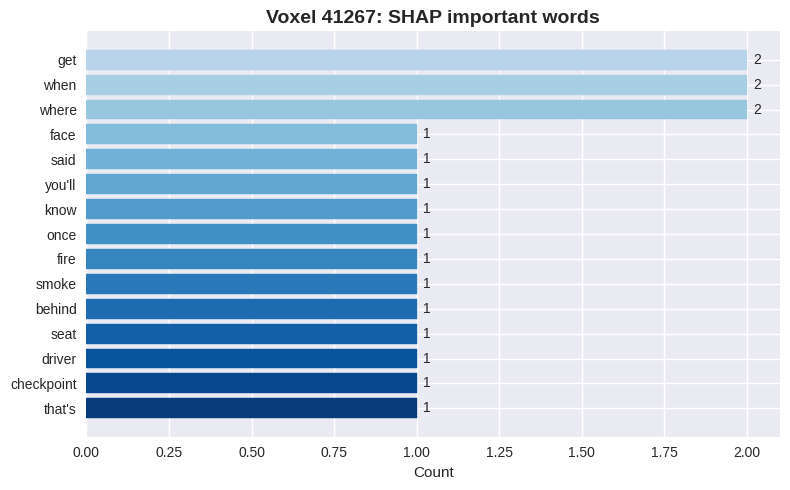


===== Voxel 31731 (CC=0.549) — SHAP =====
Top SHAP words: [("didn't", 2), ('told', 2), ('him', 2), ('get', 2), ('where', 2), ('when', 2), ('van', 1), ('stop', 1), ('empty', 1), ('sat', 1)]


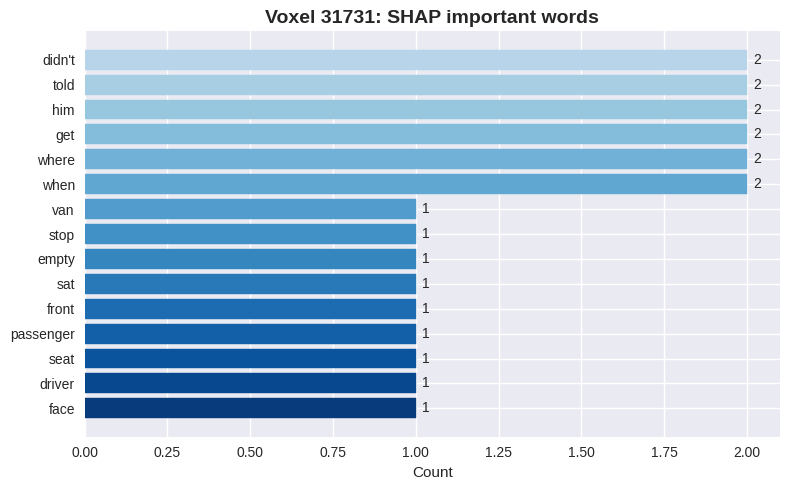


===== Voxel 49800 (CC=0.554) — SHAP =====
Top SHAP words: [("didn't", 2), ('told', 2), ('him', 2), ('where', 2), ('when', 2), ('fire', 1), ('smoke', 1), ('behind', 1), ('stop', 1), ('friend', 1)]


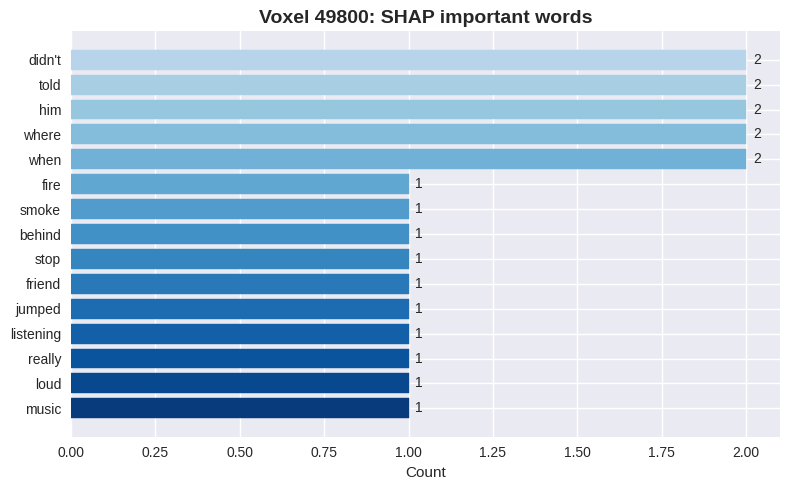


===== Voxel 35377 (CC=0.560) — SHAP =====
Top SHAP words: [("didn't", 2), ('told', 2), ('him', 2), ('when', 2), ('where', 2), ('stop', 1), ('than', 1), ('freeway', 1), ('checkpoint', 1), ("that's", 1)]


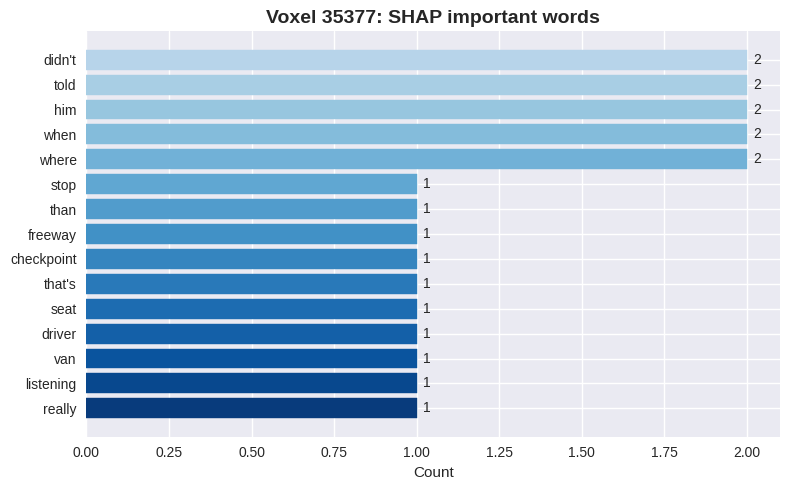


===== Voxel 35430 (CC=0.566) — SHAP =====
Top SHAP words: [("didn't", 2), ('told', 2), ('him', 2), ('when', 2), ('where', 2), ('stop', 1), ('than', 1), ('freeway', 1), ('van', 1), ('checkpoint', 1)]


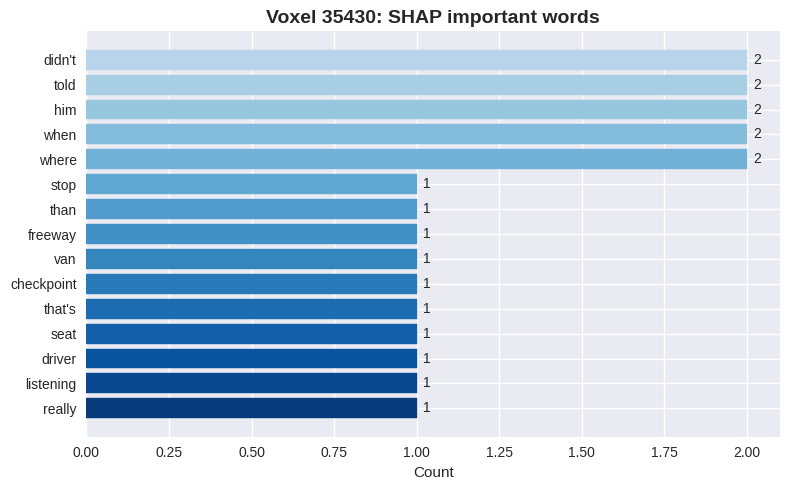

In [11]:
# SHAP
import random
from collections import Counter
import matplotlib.pyplot as plt


T, D = X_delayed.shape

sample_size = min(120, T)
sample_idx = sorted(random.sample(range(T), sample_size))

X_sample = X_delayed[sample_idx]
Xz_sample = (X_sample - mean_X[None, :]) / std_X[None, :]

top_tr_k = 15  

voxel_shap_like_info = {}

for vox in selected_voxels:
    print(f"\n=== SHAP for voxel {vox} (CC={cc_story[vox]:.3f}) ===")
    w_vox = W[:, vox]        # (D,)

    contrib = Xz_sample * w_vox[None, :]     # (sample_size, D)

    tr_imp = np.sum(np.abs(contrib), axis=1)  # (sample_size,)

    # top K TR
    top_idx_in_sample = np.argsort(tr_imp)[-top_tr_k:]
    top_trs = [sample_idx[i] for i in top_idx_in_sample]

    voxel_shap_like_info[vox] = {
        "tr_importance": tr_imp,
        "top_trs": top_trs,
    }

    print("Top TRs by SHAP:", top_trs)

for vox in selected_voxels:
    print(f"\n===== Voxel {vox} (CC={cc_story[vox]:.3f}) — SHAP =====")
    shap_trs = voxel_shap_like_info[vox]["top_trs"]

    shap_words = aggregate_words_from_tr_list(shap_trs)
    shap_words = clean_counter(shap_words)


    print("Top SHAP words:", shap_words.most_common(10))
    plot_top_words(shap_words, f"Voxel {vox}: SHAP important words")


=== LIME for voxel 41267 (CC=0.531) ===
Top TRs by LIME: [24, 3, 102, 191, 224, 28, 213, 210, 190, 194]

=== LIME for voxel 31731 (CC=0.549) ===
Top TRs by LIME: [3, 213, 190, 210, 28, 262, 24, 194, 224, 102]

=== LIME for voxel 49800 (CC=0.554) ===
Top TRs by LIME: [73, 326, 190, 40, 224, 213, 28, 194, 3, 210]

=== LIME for voxel 35377 (CC=0.560) ===
Top TRs by LIME: [224, 181, 262, 190, 213, 326, 102, 3, 194, 210]

=== LIME for voxel 35430 (CC=0.566) ===
Top TRs by LIME: [192, 326, 28, 224, 190, 262, 3, 213, 210, 194]

===== Voxel 41267 (CC=0.531) — LIME =====
Top LIME words: [('friend', 1), ('jumped', 1), ('sunset', 1), ('cars', 1), ('driving', 1), ('after', 1), ('empty', 1), ('sat', 1), ('front', 1), ('passenger', 1)]


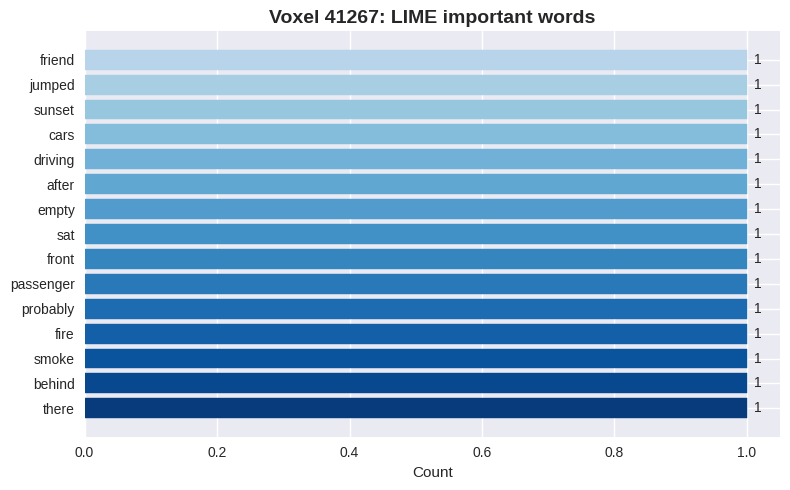


===== Voxel 31731 (CC=0.549) — LIME =====
Top LIME words: [('there', 1), ('van', 1), ('did', 1), ('not', 1), ('turn', 1), ('around', 1), ('where', 1), ('going', 1), ('fire', 1), ('smoke', 1)]


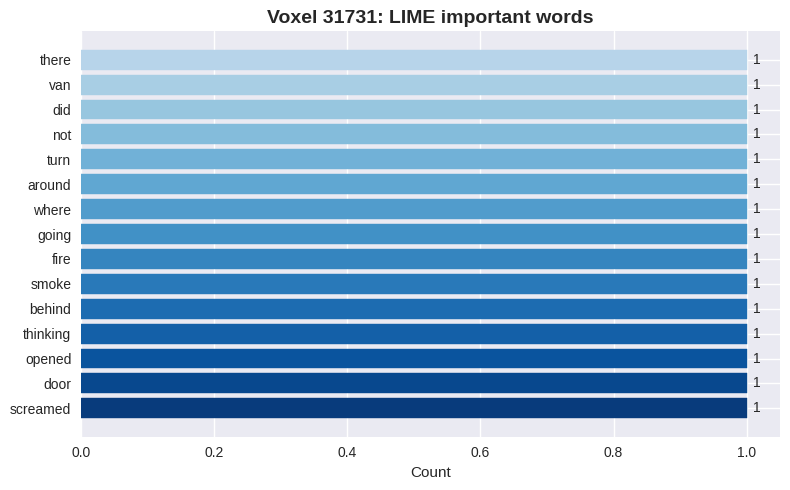


===== Voxel 49800 (CC=0.554) — LIME =====
Top LIME words: [('thousand', 1), ('six', 1), ('kissed', 1), ('losing', 1), ('new', 1), ('safe', 1), ('home', 1), ('america', 1), ('van', 1), ('grew', 1)]


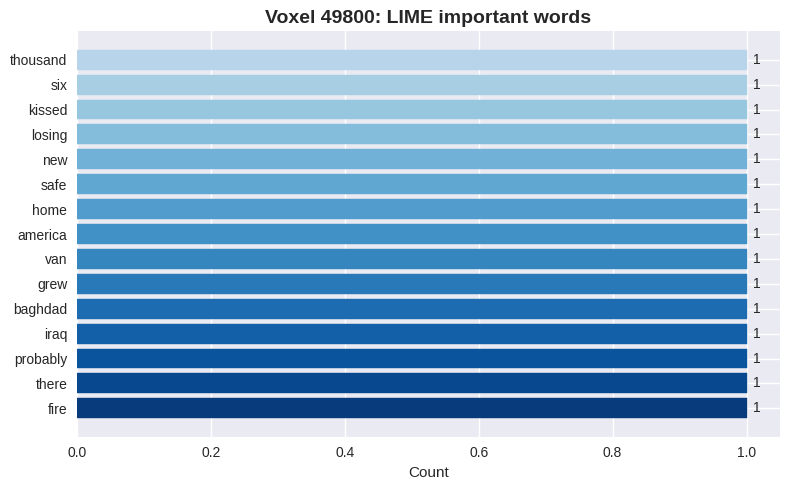


===== Voxel 35377 (CC=0.560) — LIME =====
Top LIME words: [('probably', 1), ('one', 1), ('evening', 1), ('took', 1), ('thinking', 1), ('opened', 1), ('door', 1), ('screamed', 1), ('words', 1), ('van', 1)]


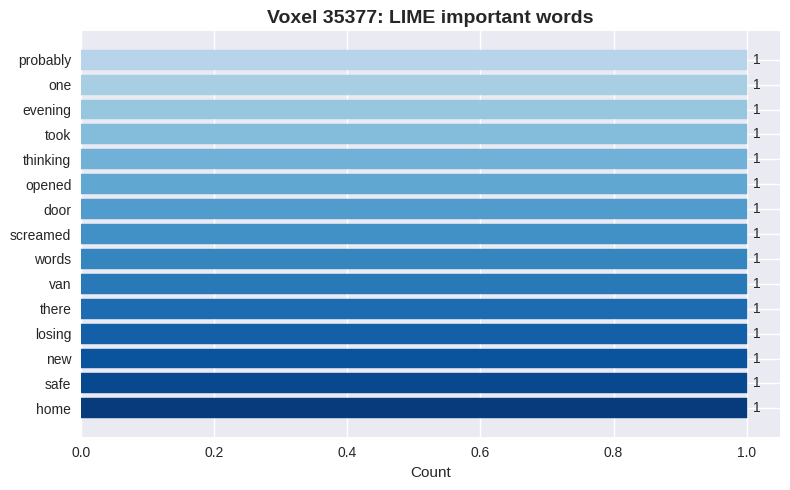


===== Voxel 35430 (CC=0.566) — LIME =====
Top LIME words: [('seat', 1), ('driver', 1), ('losing', 1), ('new', 1), ('safe', 1), ('home', 1), ('america', 1), ('fire', 1), ('smoke', 1), ('behind', 1)]


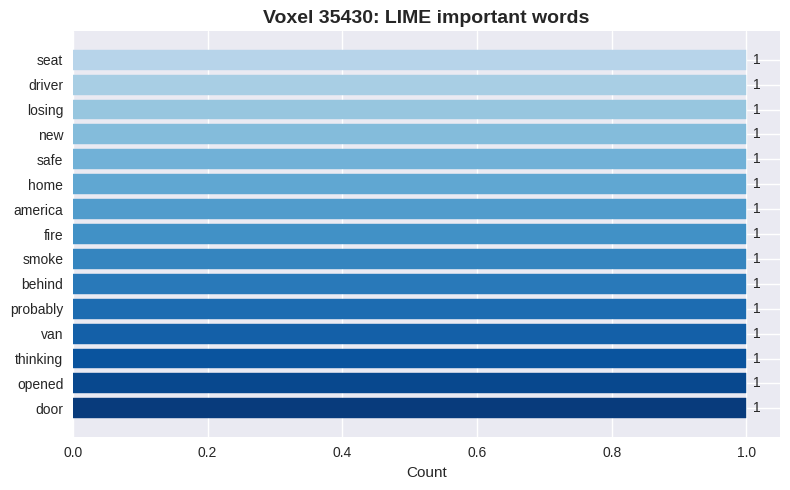

In [12]:
# LIME
def lime_like_tr_scores_for_voxel(vox, Xz_all, sample_idx,
                                  K=80, top_d=50, noise_scale=0.5, seed=123):
    rng = np.random.default_rng(seed)
    w_vox = W[:, vox]   # (D,)

    feat_idx = np.argsort(np.abs(w_vox))[-top_d:]
    w_sub = w_vox[feat_idx]

    scores = {}

    for tr in sample_idx:
        x0 = Xz_all[tr, feat_idx]  # (top_d,)

        noise = rng.normal(scale=noise_scale, size=(K, top_d))
        X_pert = x0[None, :] + noise   # (K, top_d)

        y_pert = X_pert @ w_sub        # (K,)

        d = np.linalg.norm(X_pert - x0[None, :], axis=1)
        sigma = np.median(d) + 1e-6
        weights = np.exp(- (d**2) / (2 * sigma**2))  # (K,)

        Wsqrt = np.sqrt(weights)[:, None]      # (K,1)
        Xw = Wsqrt * X_pert                    # (K, top_d)
        yw = (Wsqrt[:, 0]) * y_pert           # (K,)

        beta, *_ = np.linalg.lstsq(Xw, yw, rcond=None)  # (top_d,)

        contrib = beta * x0
        score = float(np.sum(np.abs(contrib)))

        scores[tr] = score

    return scores
    
voxel_lime_like_info = {}
top_tr_k = 10
Xz_all = (X_delayed - mean_X[None, :]) / std_X[None, :]

for vox in selected_voxels:
    print(f"\n=== LIME for voxel {vox} (CC={cc_story[vox]:.3f}) ===")
    scores = lime_like_tr_scores_for_voxel(
        vox, Xz_all, sample_idx,
        K=80, top_d=50, noise_scale=0.5, seed=vox+7
    )
    sorted_tr = sorted(scores.items(), key=lambda x: x[1])
    top_trs = [tr for tr, _ in sorted_tr[-top_tr_k:]]

    voxel_lime_like_info[vox] = {
        "scores": scores,
        "top_trs": top_trs,
    }

    print("Top TRs by LIME:", top_trs)

for vox in selected_voxels:
    print(f"\n===== Voxel {vox} (CC={cc_story[vox]:.3f}) — LIME =====")
    lime_trs = voxel_lime_like_info[vox]["top_trs"]

    lime_words = aggregate_words_from_tr_list(lime_trs)
    lime_words = clean_counter(lime_words)

    print("Top LIME words:", lime_words.most_common(10))
    plot_top_words(lime_words, f"Voxel {vox}: LIME important words")


In [13]:
from collections import Counter

def top_words_for_voxel(vox, k=15, clean_fn=None):
    shap_trs = voxel_shap_like_info[vox]["top_trs"]
    lime_trs = voxel_lime_like_info[vox]["top_trs"]

    shap_words = aggregate_words_from_tr_list(shap_trs)
    lime_words = aggregate_words_from_tr_list(lime_trs)

    if clean_fn is not None:
        shap_words = clean_fn(shap_words)
        lime_words = clean_fn(lime_words)

    return shap_words, lime_words


def print_overlap(vox, k=15, clean_fn=None):
    shap_words, lime_words = top_words_for_voxel(vox, k=k, clean_fn=clean_fn)

    shap_top = [w for w, _ in shap_words.most_common(k)]
    lime_top = [w for w, _ in lime_words.most_common(k)]

    shap_set = set(shap_top)
    lime_set = set(lime_top)

    common    = shap_set & lime_set
    shap_only = shap_set - lime_set
    lime_only = lime_set - shap_set

    print(f"\n===== Voxel {vox} (CC={cc_story[vox]:.3f}) =====")
    print("Common words in SHAP & LIME:", common)
    print("SHAP-only words:", shap_only)
    print("LIME-only words:", lime_only)

for vox in selected_voxels:
    print_overlap(vox, k=15, clean_fn=clean_counter)



===== Voxel 41267 (CC=0.531) =====
Common words in SHAP & LIME: {'fire', 'behind', 'smoke'}
SHAP-only words: {'face', "that's", 'checkpoint', 'seat', 'once', 'know', 'where', 'get', 'said', 'when', "you'll", 'driver'}
LIME-only words: {'sat', 'there', 'cars', 'sunset', 'probably', 'front', 'passenger', 'friend', 'driving', 'after', 'empty', 'jumped'}

===== Voxel 31731 (CC=0.549) =====
Common words in SHAP & LIME: {'where', 'van'}
SHAP-only words: {'sat', 'seat', 'front', 'passenger', 'get', 'him', 'stop', "didn't", 'when', 'face', 'empty', 'driver', 'told'}
LIME-only words: {'screamed', 'there', 'did', 'thinking', 'around', 'opened', 'turn', 'not', 'going', 'behind', 'smoke', 'fire', 'door'}

===== Voxel 49800 (CC=0.554) =====
Common words in SHAP & LIME: {'fire'}
SHAP-only words: {'where', 'loud', 'him', 'listening', 'stop', 'friend', 'music', "didn't", 'behind', 'smoke', 'when', 'jumped', 'really', 'told'}
LIME-only words: {'kissed', 'there', 'america', 'thousand', 'van', 'probably

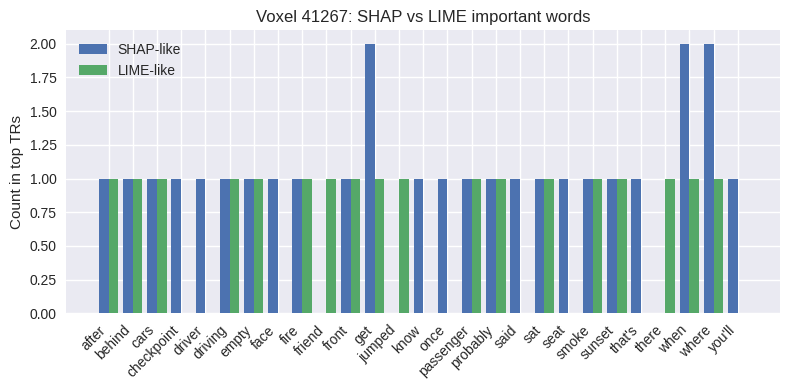

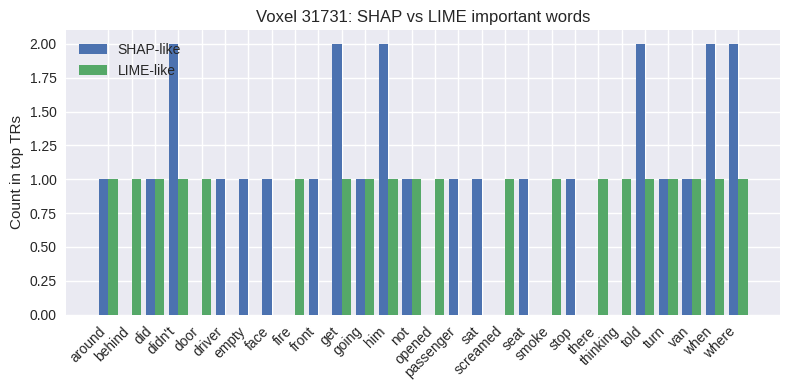

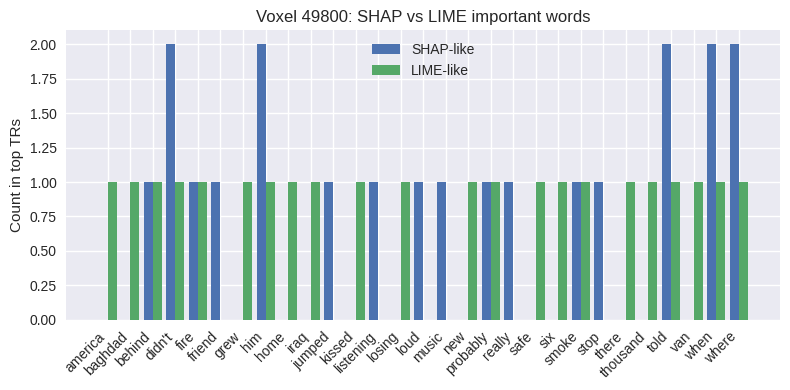

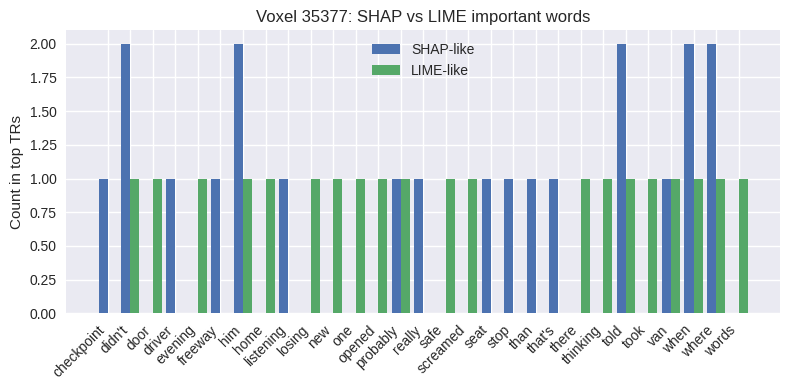

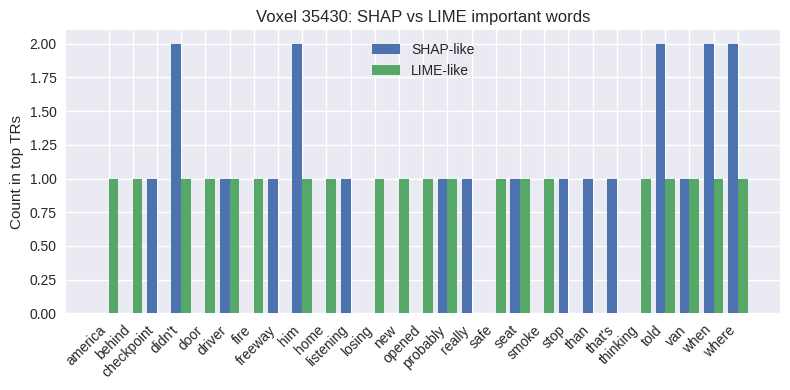

In [14]:
def plot_shap_lime_words(vox, k=15, clean_fn=None):
    shap_words, lime_words = top_words_for_voxel(vox, k=k, clean_fn=clean_fn)

    shap_top = shap_words.most_common(k)
    lime_top = lime_words.most_common(k)

    vocab = sorted(set(w for w, _ in shap_top) | set(w for w, _ in lime_top))

    shap_counts = [shap_words.get(w, 0) for w in vocab]
    lime_counts = [lime_words.get(w, 0) for w in vocab]

    x = np.arange(len(vocab))
    width = 0.4

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, shap_counts, width, label="SHAP-like")
    plt.bar(x + width/2, lime_counts, width, label="LIME-like")
    plt.xticks(x, vocab, rotation=45, ha="right")
    plt.ylabel("Count in top TRs")
    plt.title(f"Voxel {vox}: SHAP vs LIME important words")
    plt.legend()
    plt.tight_layout()

    pdf_name = f"Voxel_{vox}_SHAP_vs_LIME_words.pdf"
    pdf_name = pdf_name.replace(" ", "_")
    plt.savefig(pdf_name, format="pdf", bbox_inches="tight")

    plt.show()
    
for vox in selected_voxels:
    plot_shap_lime_words(vox, k=15, clean_fn=clean_counter)
